## For the explanation of stochstic interventions

Generate simluated datasets

In [260]:
import os
os.getcwd()

'/Users/mag7273/Github/stochastic_intervention_causal_estimation'

In [261]:
import matplotlib.pyplot as plt
import proplot as pplt
from matplotlib import cm
import numpy as np
import torch
import torch.nn.functional as F
from pyro.distributions import AsymmetricLaplace

Text(0.5, 1.0, 'Y')

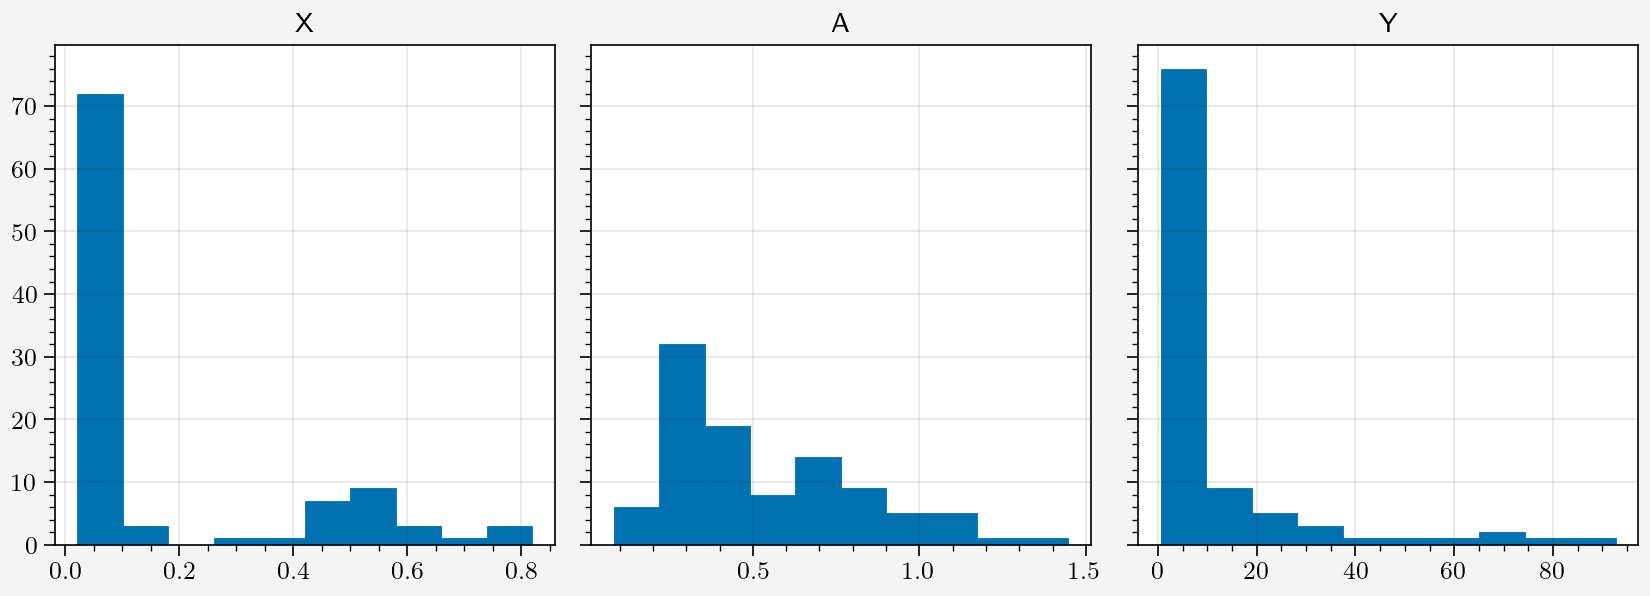

In [262]:
torch.manual_seed(110104)

N = 100  # data size
Z = (torch.rand(N) < 0.75).float() # aux latent
noise_A = torch.randn(N)
skew = 0.5
exo = 0.1
X = (Z * (-3 + 0.5 * noise_A) + (1 - Z) * (0.25 + 0.5 * noise_A)).sigmoid() # Urbanization indicator
A = AsymmetricLaplace(X.sqrt(), exo, skew).sample() # air pollution

def gps(a: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    None

noise_Y = np.random.poisson(torch.rand(N))
f = lambda X, A, noise: 100 * X * (0.25 + (10 * (A - 1.0)).sigmoid()) + noise
Y = f(X, A, noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=3)
ax[0].hist(X); ax[0].set_title("X")
ax[1].hist(A); ax[1].set_title("A")
ax[2].hist(Y); ax[2].set_title("Y")

Plot example dose response curves

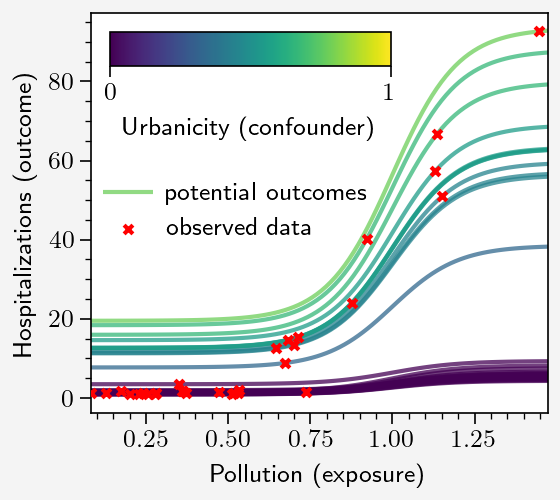

In [263]:
nlevels = 100
Nplot = 30
# alims = [0.0, 1.0]
alims = [A.min(), A.max() + 0.025]
ylims = [0.0, 1.25]
A_cf = torch.linspace(*alims, nlevels)

Y_cf = f(X, A_cf[:, None], noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(2.8, 2.5))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('viridis', 10)
colors = cmap(X.numpy())

j1 = X[:Nplot].argmax().item()
for j in range(Nplot):
    l = ("potential outcomes" if (j == j1) else None)
    ax.plot(A_cf, Y_cf[:, j], color=colors[j], alpha=0.75, lw=1.5, label=l)


ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", marker='x', z=3, label="observed data")
ax.colorbar(cmap, loc="ul", label="Urbanicity (confounder)", alpha=0.0, length=10, ticks=1, values=[0, 1], tickminor=False)
ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.legend(ncols=1, loc=[0.0, 0.4], framealpha=0.0)
# ax.set_ylim(*ylims)
ax.grid(False)
plt.savefig("figures/simulated_data.png", bbox_inches="tight")

tensor(0.5310)


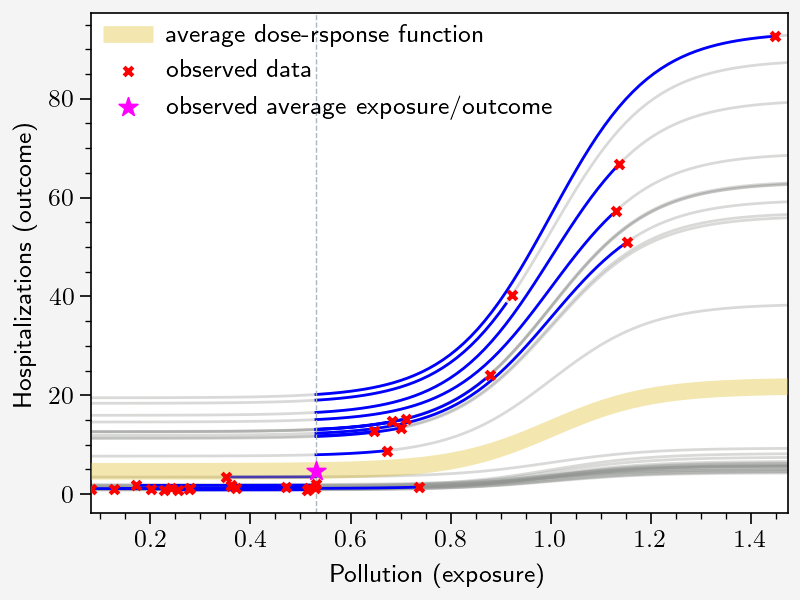

In [264]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(4, 3))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('greys', 20)
colors = cmap(X.numpy())

ax.plot(A_cf, Y_cf[:, :Nplot], color="grey", alpha=0.35, lw=1)

# nr, nc = 50, 100
# U = np.zeros((nr, nc))
# for i in range(nr):
#     for j in range(nc):
#         y = ylims[1] - (i + 1) * (ylims[1] - ylims[0]) / nr
#         a = alims[0] + (j + 1) * (alims[1] - alims[0]) / nc
#         total_dist = ((y - Y).pow(2) + (a - A).pow(2)).sqrt()
#         U[i, j] = total_dist.min().item()

# U = (U - U.min()) / (U.max() - U.min())

k = np.where(A_cf >= A.mean())[0][0]
Ak = A_cf[k]
print(Ak)


for j in range(Nplot):
    if A[j] <= Ak:
        ix = (A_cf <= Ak) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= Ak)
    l == "implied counterfactuals" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="blue",  lw=1, label=l)

# ax.scatter(A, Y, s=10, c="red", marker='x', z=3, label="data")
ax.plot(A_cf, Y_cf.mean(1), lw=6, c="gold", ls='-',  alpha=0.33, z=3, label="average dose-rsponse function")
ax.axvline(x=Ak, ls='--', c="grey5", lw=0.5)
ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", marker='x', z=4, label="observed data")
ax.scatter([Ak], [Y_cf.mean(1)[k]], s=50, c="magenta", marker='*',  z=4, label="observed average exposure/outcome")
# ax.imshow(U, extent=[alims[0], alims[1], ylims[0], ylims[1]], cmap="greys", aspect='auto')
# ax.colorbar(cmap, label="Uncertainty")
ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.legend(ncols=1, framealpha=0.0)
ax.grid(False)
# 

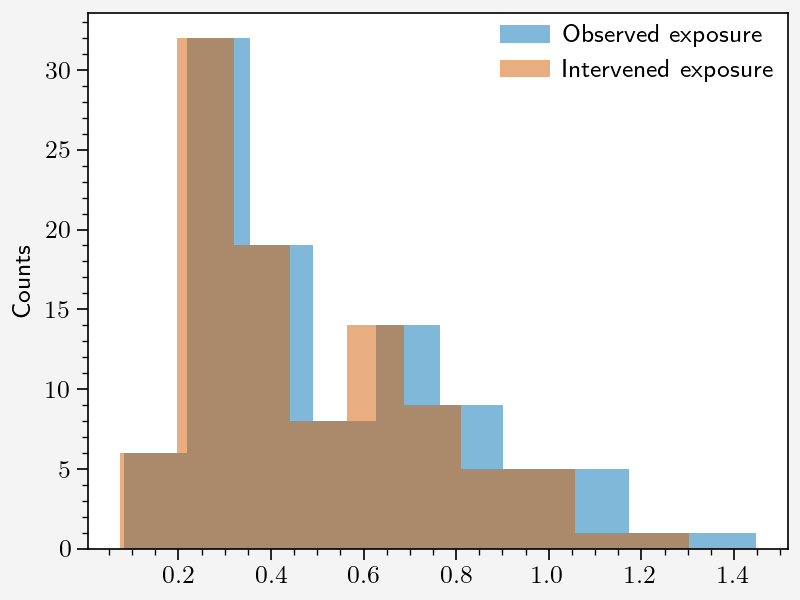

In [265]:
fig = pplt.figure(figsize=(4, 3))

d = 0.9
# A_d = (A.logit() + d).sigmoid()
# A_d = (A + d).clamp(0, 1)
A_d = (A * d) # .clamp(0, 1)
Y_d = f(X, A_d, noise_Y)

plt.hist(A, alpha=0.5, label="Observed exposure")
plt.hist(A_d, alpha=0.5, label="Intervened exposure")
plt.legend(ncols=1, framealpha=0.0)
# ax.set_ylabel("Outcome ($Y$)");
# plt.xlabel("Exposure ($A$)");
plt.ylabel("Counts")
plt.grid(False)


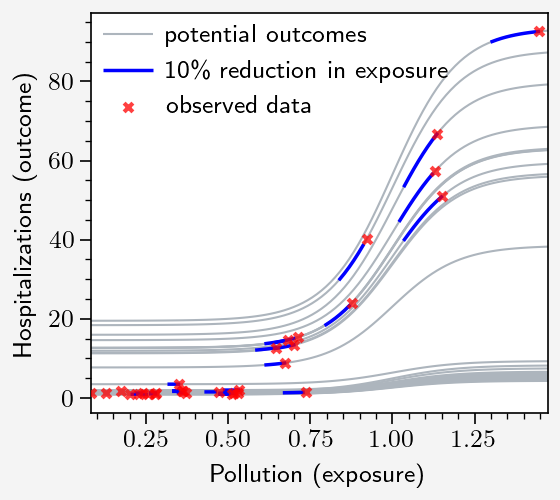

In [266]:
fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(2.8, 2.5))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('greys', 20)
colors = cmap(X.numpy())

labs = ["potential outcomes"] + [None] * (Nplot - 1)
ax.plot(A_cf, Y_cf[:,:Nplot], color="grey5", lw=0.75, label=labs, ls="-")

# nr, nc = 50, 100
# U = np.zeros((nr, nc))
# for i in range(nr):
#     for j in range(nc):
#         y = ylims[1] - (i + 1) * (ylims[1] - ylims[0]) / nr
#         a = alims[0] + (j + 1) * (alims[1] - alims[0]) / nc
#         total_dist = ((y - Y).pow(2) + (a - A).pow(2)).sqrt()
#         U[i, j] = total_dist.min().item()

# U = (U - U.min()) / (U.max() - U.min())


for j in range(Nplot):
    if A[j] <= A_d[j]:
        ix = (A_cf <= A_d[j]) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= A_d[j])
    l = "10\% reduction in exposure" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="blue", alpha=1.0, lw=1.25, label=l)

# ax.scatter(A, Y, s=10, c="red", marker='x', z=3, label="data")
# ax.scatter(A_d[:Nplot], Y_d[:Nplot], s=25, c="blue", marker='.', z=4, alpha=0.5, label="counterfactual data")
ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", marker='x', z=3, alpha=0.75, label="observed data")
# ax.imshow(U, extent=[alims[0], alims[1], ylims[0], ylims[1]], cmap="greys", aspect='auto')
# ax.colorbar(cmap, label="Uncertainty")


# ax.axvline(a, c="grey6", alpha=0.5, lw=0.25)
# ax.axvline(a + d, c="grey6", alpha=0.5, lw=0.25)
# ax.text(a + d/2 - 0.01, b, s="$\delta$", c="blue", fontsize=12, weight='bold')
# # print(a)
# xmin, xmax = [a + 0.005, a + d - 0.005] if d > 0 else [a + d + 0.005, a - 0.005]
# xmin, xmax = float(xmin), float(xmax)

# ax.axhline(y=b-0.02, xmin=xmin, xmax=xmax, c="blue", lw=0.5)
# ax.axvline(x=xmin, ymin=b-0.015, ymax=b+0.025, c="orange", lw=0.5)
# ax.axvline(x=xmax, ymin=b-0.015, ymax=b+0.025, c="orange", lw=0.5)

ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.legend(ncols=1, framealpha=0.0)
ax.grid(False)
plt.savefig("figures/simulated_intervention.png", bbox_inches="tight")

# # 

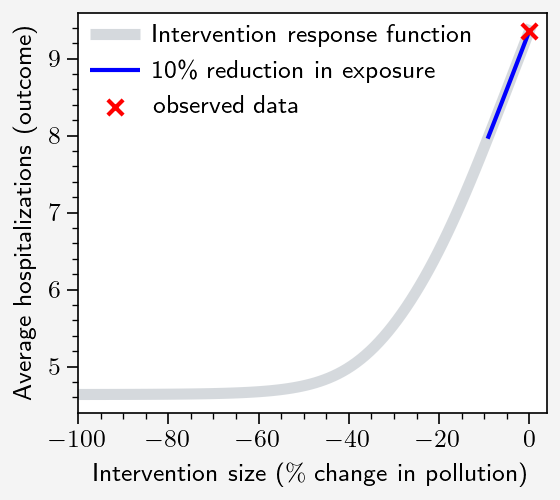

In [267]:
# dlims = (-2, 2)
dlims = (0.0, 1)
ds = torch.linspace(*dlims, nlevels)
# A_ds = (A[None].logit() + ds[:, None]).sigmoid()
A_ds = (A[None] * ds[:, None]) # .clamp(0, 1)
Y_ds = f(X, A_ds, noise_Y)
irf = Y_ds.mean(1)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(2.8, 2.5))

# cmap = cm.get_cmap('viridis', 20)
# colors = cmap(X.numpy())

# for j in range(N):
#     l = "Potential outcomes" if j == (N//2) else None
#     ax.plot(A_cf, Y_cf[:, j], color=colors[j], alpha=0.5, lw=1, label=l)

x = (ds - 1) * 100
plt.plot(x, irf, lw=4, c="grey5", ls='-',  alpha=0.5, label="Intervention response function")
m = Y.mean().item()
ix = (ds >= d) & (ds <= 1)
ax.plot(x[ix], irf[ix], c="blue", label="10\% reduction in exposure")
ax.scatter([0], [Y.mean()], s=30, m="x", c= "red", z=3, label="observed data")
# ax.axvline(x=0.0, ymax=0.4, lw=0.5, ls="--")
ax.legend(loc="ul", ncols=1, framealpha=0.)
ax.set_xlim(x.min(), x.max() + 4)
# ax.set_ylim(*ylims)
ax.set_ylabel("Average hospitalizations (outcome)");
ax.set_xlabel("Intervention size ($\%$ change in pollution)");
ax.grid(False)
plt.savefig("figures/simulated_irf.png", bbox_inches="tight")


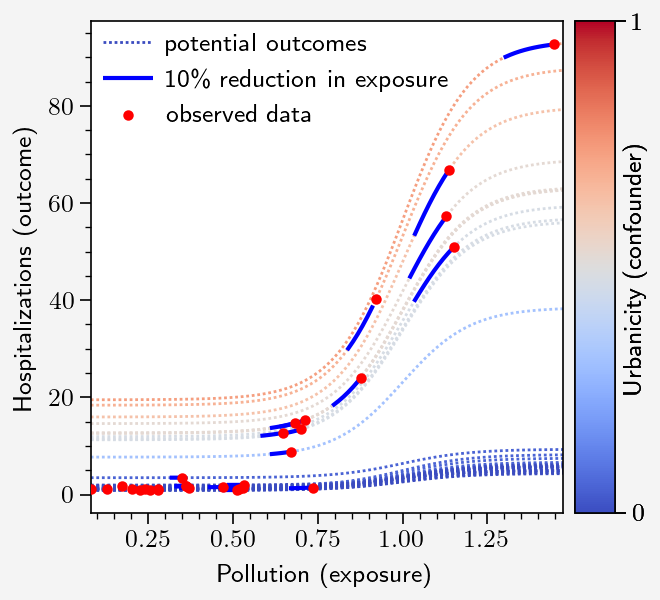

In [268]:
nlevels = 100
Nplot = 30
# alims = [0.0, 1.0]
ylims = [0.0, 1.25]
A_cf = torch.linspace(*alims, nlevels)

Y_cf = f(X, A_cf[:, None], noise_Y)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.3, 3.0))
plt.rcParams.update({"text.usetex": True})

cmap = cm.get_cmap('coolwarm', 20)
colors = cmap(X.numpy())

j1 = X[:Nplot].argmax().item()
for j in range(Nplot):
    l = ("potential outcomes" if (j == 0) else None)
    ax.plot(A_cf, Y_cf[:, j], color=colors[j], lw=1.0, ls=(0, (1, 1)), label=l)


for j in range(Nplot):
    if A[j] <= A_d[j]:
        ix = (A_cf <= A_d[j]) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= A_d[j])
    l = "10\% reduction in exposure" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="blue", alpha=1.0, lw=1.5, label=l)
    # ax.scatter([A_d[j]], [Y_d[j]], color="orange", alpha=1.0, s=30, m=".")


ax.scatter(A[:Nplot], Y[:Nplot], s=10, c="red", z=3, label="observed data")
cb = ax.colorbar(cmap, loc="r", ticks=1, values=[0, 1], tickminor=False)
cb.set_label("Urbanicity (confounder)", labelpad=-8)
ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.legend(ncols=1, loc="ul", framealpha=0.0)
# ax.set_ylim(*ylims)
ax.grid(False)
plt.savefig("figures/simulated_data.pdf", bbox_inches="tight", dpi=600)

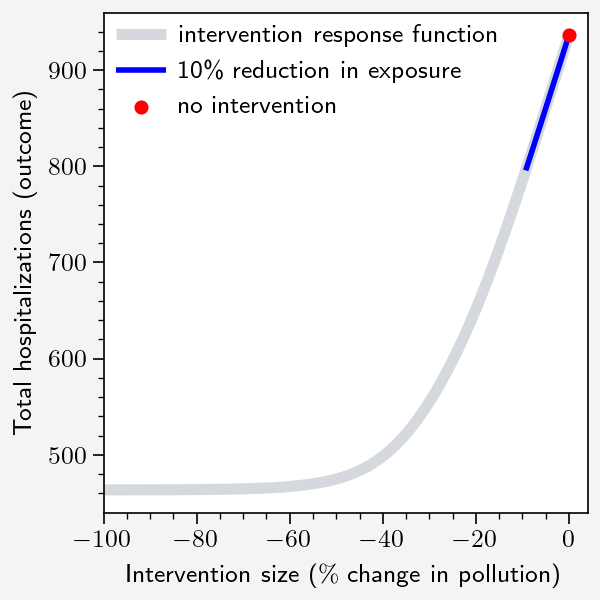

In [269]:
# dlims = (-2, 2)
dlims = (0.0, 1)
ds = torch.linspace(*dlims, nlevels)
# A_ds = (A[None].logit() + ds[:, None]).sigmoid()
A_ds = (A[None] * ds[:, None])# .clamp(0, 1)
Y_ds = f(X, A_ds, noise_Y)
irf = Y_ds.mean(1)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 3.0))

# cmap = cm.get_cmap('viridis', 20)
# colors = cmap(X.numpy())

# for j in range(N):
#     l = "Potential outcomes" if j == (N//2) else None
#     ax.plot(A_cf, Y_cf[:, j], color=colors[j], alpha=0.5, lw=1, label=l)

x = (ds - 1) * 100
plt.plot(x, N * irf, lw=4, alpha=0.5, c="grey5",  label="intervention response function")
m = Y.mean().item()
ix = (ds >= d) & (ds <= 1)
ax.plot(x[ix], N * irf[ix], lw=2, c="blue", label="10\% reduction in exposure")
ax.scatter([0], [N * Y.mean()], s=80, m=".", c= "red", z=3, label="no intervention")
# ax.scatter([(d - 1) * 100], [Y_d.mean()], s=20, m=".", c= "red", z=3)
# ax.axvline(x=0.0, ymax=0.4, lw=0.5, ls="--")
ax.legend(loc="ul", ncols=1, framealpha=0.)
ax.set_xlim(x.min(), x.max() + 4)
# ax.set_ylim(*ylims)
ax.set_ylabel("Total hospitalizations (outcome)");
ax.set_xlabel("Intervention size ($\%$ change in pollution)");
ax.grid(False)
plt.savefig("figures/irf.pdf", bbox_inches="tight", dpi=600)


tensor(0.5310)


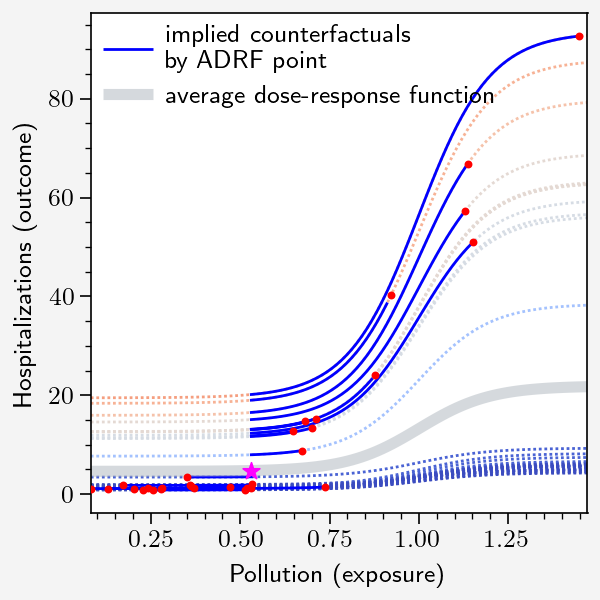

In [270]:

adrf = Y_cf.mean(1)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 3.0))
j1 = X[:Nplot].argmax().item()


k = np.where(A_cf >= A.mean())[0][0]
# k = np.where(A_cf >= 0.5)[0][0]
Ak = A_cf[k]
print(Ak)

cmap = cm.get_cmap('coolwarm', 20)
colors = cmap(X.numpy())

j1 = X[:Nplot].argmax().item()
for j in range(Nplot):
    # l = ("potential outcomes" if (j == 0) else None)
    l= None
    ax.plot(A_cf, Y_cf[:, j], color=colors[j], lw=1.0, ls=(0, (1, 1)), label=l)


for j in range(Nplot):
    if A[j] <= Ak:
        ix = (A_cf <= Ak) & (A_cf >= A[j])
    else:
        ix = (A_cf <= A[j]) & (A_cf >= Ak)
    l = "implied counterfactuals\nby ADRF point" if j == 0 else None
    ax.plot(A_cf[ix], Y_cf[ix, j], color="blue",  lw=1, label=l)

ax.scatter(A[:Nplot], Y[:Nplot], s=5, c="red", z=3)

plt.plot(A_cf, adrf,  lw=4, alpha=0.5, c="grey5",  label="average dose-response function")

ax.scatter([Ak], [adrf[k]], s=40, m="*", z=3, c= "magenta")

# ax.axvline(x=Ak, lw=1.0, alpha=0.2, ls="--", c="blue")
ax.legend(loc="ul", ncols=1, framealpha=0.)
# ax.set_ylim(*ylims)
ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.grid(False)
plt.savefig("figures/implied_counterfactuals.pdf", bbox_inches="tight", dpi=600)


tensor(0.5310)


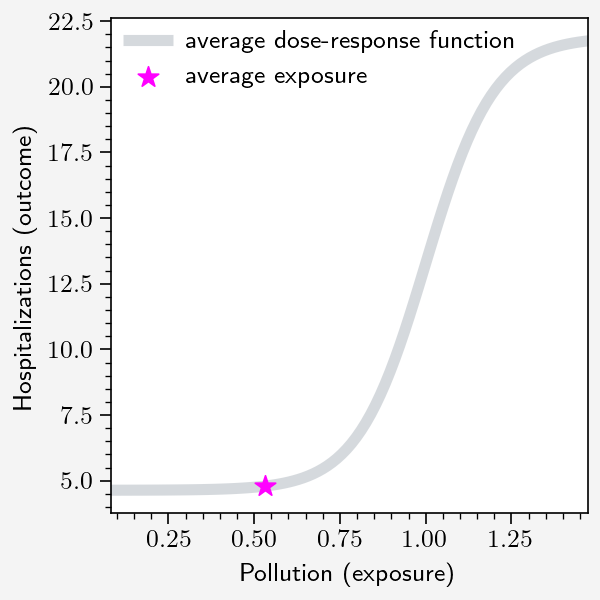

In [271]:

adrf = Y_cf.mean(1)

fig, ax = pplt.subplots(nrows=1, ncols=1, figsize=(3.0, 3.0))
j1 = X[:Nplot].argmax().item()

plt.plot(A_cf, adrf,  lw=4, alpha=0.5, c="grey5",  label="average dose-response function")

k = np.where(A_cf >= A.mean())[0][0]
Ak = A_cf[k]
print(Ak)


ix = (A_cf <= Ak) & (A_cf >= A[j])
# ax.plot(A_cf[ix], adrf[ix], c="blue", lw=1, label="10\% decrease over the ADRF")

ax.scatter([Ak], [adrf[k]], s=60, m="*", c= "magenta", z=3, label="average exposure")

# ax.axvline(x=0.0, ymax=0.4, lw=0.5, ls="--")
ax.legend(loc="ul", ncols=1, framealpha=0.)
# ax.set_ylim(*ylims)
ax.set_ylabel("Hospitalizations (outcome)");
ax.set_xlabel("Pollution (exposure)");
ax.grid(False)
plt.savefig("figures/adrf_alone.pdf", bbox_inches="tight", dpi=600)


In [272]:
# export the example datset
import pickle 

D = dict(
    X=X,
    A=A,
    A_cf=A_cf,
    Y_cf=Y_cf,
    ds=ds,
    A_ds=A_ds,
    Y_ds=Y_ds,
    gps=gps
)
with open("dataset/toy.pkl", "wb") as io:
    pickle.dump(D, io)